# Implementing Expectation-Maximization algorithm for GMM

Gaussian Mixture Model for soft clustering of the data. Work done for Coursera test. 

In [1]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_classification
from scipy.stats import multivariate_normal as mult_norm
from scipy.stats import norm
%matplotlib inline

<b>Create Dataset:</b>


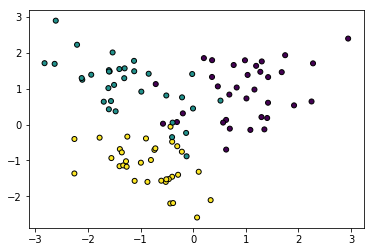

In [3]:
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=3)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k');

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


In [4]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    ### Iterate over data points
    for i in range(N):
        temp_prob = [0] * C
        temp_sum = 0
        ### iterate over n_custers
        for c in range(C):
            # create multivariate normal with mu and sigma for current cluster
            c_dist = mult_norm(mu[c],sigma[c])
            # get pdf for current point and multiply for weight
            temp_prob[c] = pi[c] * c_dist.pdf(X[i]) 
            temp_sum += temp_prob[c]
        # get q(t) probabilities by normalizing the calculated values for their sum
        gamma[i] = temp_prob / temp_sum
    return gamma

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$ to find optimal values of $\pi$, $\mu$, $\Sigma$. 

In [5]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    # sum of gammas for each cluster, to be used as denominator
    N_ks = np.sum(gamma, axis=0)
    pi = np.zeros([C])
    mu = np.zeros([C,2])
    sigma = np.zeros([C,2,2])
    for c in range(C):
        #update pi
        pi[c] = 1/N * N_ks[c]
        #update mu
        mu[c] = 1/N_ks[c]*np.dot(gamma[:,c].reshape(N,1).T, X)
        # means
        x_mu = np.matrix(X - mu[c])
        #print(x_mu.shape)        
        ## covariances
        sigma[c] = np.array(1 / N_ks[c] * np.dot(np.multiply(x_mu.T,  gamma[:, c]), x_mu))   
    return pi, mu, sigma

### Implement Loss function - Variational Lower Bound

Variational Lower Bound function to track convergence. Stop EM iterations when $\mathcal{L}$ saturates (should never decrease).

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [6]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    
    loss = 0
    for i in range(N):
        i_loss = 0
        i_loss_a = 0
        i_loss_b = 0
        z_s = np.where(gamma[i] == np.amax(gamma[i]),1,0)
        for c in range(C):
            # create multivariate normal with mu and sigma for current cluster
            c_dist = mult_norm(mu[c],sigma[c])
            #Correct:
            i_loss_a += gamma[i,c]*(np.log(pi[c])+ np.log(np.amax([c_dist.pdf(X[i]), 1e-320])))
            i_loss_b += gamma[i,c]*np.log(np.amax([gamma[i,c], 1e-320]))
        loss += i_loss_a - i_loss_b
    return loss

### Training Loop

- start at random values of $\pi$, $\mu$ and $\Sigma$
- train until $\mathcal{L}$ stops changing  
- EM algorithm sometimes stops at local optima. Restart algorithm multiple times from different starting positions to avoid issue. 
- Training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than tolerance.

In [12]:
def train_EM(X, C, rtol=1e-3, max_iter=50, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = -1e6
    best_pi = None
    best_mu = None
    best_sigma = None
    tot_loss = None

    for _ in range(restarts):
        try:
            loss_iter = []
            list_pi = np.array([np.random.uniform() for _ in range(C)])
            pi = list_pi/sum(list_pi)
            mu = np.array([X[np.random.randint(0,N)] for _ in range(C)])
            sigma=np.array([np.identity(2), np.identity(2), np.identity(2)])
            
            for i in range(max_iter):
                #print('iter:', i)
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                #print(pi)
                #print(mu)
                #print(sigma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                #print('loss:',loss)
                loss_iter.append(loss)
                if len(loss_iter) < 2 : continue
                if np.abs((loss_iter[-1] - loss_iter[-2])/loss_iter[-2]) < rtol : break
            
            if loss_iter[-1]>= best_loss:
                best_loss = loss_iter[-1]
                best_pi = pi
                best_mu = mu
                best_sigma= sigma
                tot_loss = loss_iter
        
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma, tot_loss

In [13]:
best_loss, best_pi, best_mu, best_sigma, tot_loss = train_EM(X1, 3)

In [14]:
tot_loss

[-310.43707495175579,
 -301.65680894177063,
 -296.39492534870533,
 -292.92297754113014,
 -291.22189812375171,
 -290.39205564801551,
 -289.89438028967021,
 -289.54616743414329,
 -289.27934164561879]

# Check result - Plot

Assign a cluster label as the most probable cluster index, which is $\gamma$ computed on last E-step iteration.

In [15]:
gamma = E_step(X1, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)

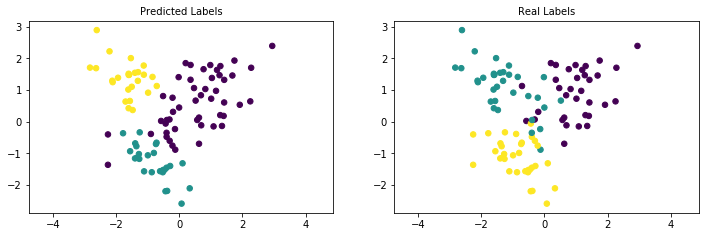

In [16]:
plt.figure(figsize=(12, 12))
#plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)

plt.subplot(321)
plt.title("Predicted Labels", fontsize='medium')
plt.scatter(X1[:, 0], X1[:, 1], c=labels, s=30)
plt.axis('equal')

plt.subplot(322)
plt.title("Real Labels", fontsize='medium')
plt.scatter(X1[:, 0], X1[:, 1], c=Y1, s=30)
plt.axis('equal')
plt.show()